In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.misc

vgg19_npy_path='../vgg19.npy'
data_dict = np.load(vgg19_npy_path, encoding='latin1').item()
print("npy file loaded")

npy file loaded


In [2]:
# Image dimensions constants. 
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_CHANNELS = 3

# Number of iterations to run.
ITERATIONS = 150  # 

In [3]:
# VGG-19 architecture
VGG_MEAN = [103.939, 116.779, 123.68]
def VGG19():
    graph = {}
    rgb = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['input'] = rgb

    # Convert RGB to BGR
    red, green, blue = tf.split(3, 3, rgb)
    assert red.get_shape().as_list()[1:] == [224, 224, 1]
    assert green.get_shape().as_list()[1:] == [224, 224, 1]
    assert blue.get_shape().as_list()[1:] == [224, 224, 1]
    bgr = tf.concat(3, [
        blue - VGG_MEAN[0],
        green - VGG_MEAN[1],
        red - VGG_MEAN[2],
    ])
    print(bgr.get_shape().as_list()[1:])
    
    
    graph['conv1_1'] = conv_layer(bgr, "conv1_1")
    graph['conv1_2'] = conv_layer(graph['conv1_1'], "conv1_2")
    graph['pool1'] = avg_pool(graph['conv1_2'], 'pool1')
    
    graph['conv2_1'] = conv_layer(graph['pool1'], "conv2_1")
    graph['conv2_2'] = conv_layer(graph['conv2_1'], "conv2_2")
    graph['pool2'] = avg_pool(graph['conv2_2'], 'pool2')
    
    graph['conv3_1'] = conv_layer(graph['pool2'], "conv3_1")
    graph['conv3_2'] = conv_layer(graph['conv3_1'], "conv3_2")
    graph['conv3_3'] = conv_layer(graph['conv3_2'], "conv3_3")
    graph['conv3_4'] = conv_layer(graph['conv3_3'], "conv3_4")
    graph['pool3'] = avg_pool(graph['conv3_4'], 'pool3')
    
    graph['conv4_1'] = conv_layer(graph['pool3'], "conv4_1")
    graph['conv4_2'] = conv_layer(graph['conv4_1'], "conv4_2")
    graph['conv4_3'] = conv_layer(graph['conv4_2'], "conv4_3")
    graph['conv4_4'] = conv_layer(graph['conv4_3'], "conv4_4")
    graph['pool4'] = avg_pool(graph['conv4_4'], 'pool4')
    
    graph['conv5_1'] = conv_layer(graph['pool4'], "conv5_1")
    graph['conv5_2'] = conv_layer(graph['conv5_1'], "conv5_2")
    graph['conv5_3'] = conv_layer(graph['conv5_2'], "conv5_3")
    graph['conv5_4'] = conv_layer(graph['conv5_3'], "conv5_4")
    graph['pool5'] = avg_pool(graph['conv5_4'], 'pool5')
    
    graph['fc6'] = fc_layer(graph['pool5'], "fc6")
    assert graph['fc6'].get_shape().as_list()[1:] == [4096]
    graph['relu6'] = tf.nn.relu(graph['fc6'])
    
    graph['fc7'] = fc_layer(graph['relu6'], "fc7")
    graph['relu7'] = tf.nn.relu(graph['fc7'])
    
    graph['fc8'] = fc_layer(graph['relu7'], "fc8")
    
    graph['prob'] = tf.nn.softmax(graph['fc8'], name="prob")
    
    data_dict = None
    print("build model finished")
    return graph
    
def avg_pool(bottom, name):
    return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def conv_layer(bottom, name):
    with tf.variable_scope(name):
        filt = get_conv_filter(name)

        conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

        conv_biases = get_bias(name)
        bias = tf.nn.bias_add(conv, conv_biases)

        relu = tf.nn.relu(bias)
        return relu
    
def fc_layer(bottom, name):
    with tf.variable_scope(name):
        shape = bottom.get_shape().as_list()
        dim = 1
        for d in shape[1:]:
            dim *= d
        x = tf.reshape(bottom, [-1, dim])

        weights = get_fc_weight(name)
        biases = get_bias(name)

        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.
        fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

        return fc
    
def get_conv_filter(name):
    return tf.constant(data_dict[name][0], name="filter")

def get_bias(name):
    return tf.constant(data_dict[name][1], name="biases")

def get_fc_weight(name):
    return tf.constant(data_dict[name][0], name="weights")

In [4]:
model = VGG19()

[224, 224, 3]
build model finished


0.0


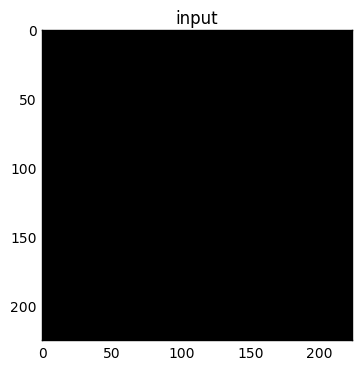

In [5]:
%matplotlib inline
input_image = np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS))
plt.figure()
plt.imshow(input_image[0])
print(np.mean(input_image))
plt.title('input')

In [6]:
one_hot_y = tf.one_hot(694, 1000) # paddlewheel
total_loss = tf.nn.softmax_cross_entropy_with_logits(tf.reshape(model['fc8'],(1000,)), one_hot_y)
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(input_image))

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%30 == 0:
        result_image = sess.run(model['input'])
        print('Iteration {}'.format(it))
        print('cost: ', sess.run(total_loss))

        if not os.path.exists('output/'):
            os.mkdir('output/')

        filename = 'output/%d.png' % (it)
        gray = cv2.cvtColor(result_image[0],cv2.COLOR_RGB2GRAY)
        scipy.misc.imsave(filename, gray)


Iteration 0
cost:  8.33062
Iteration 30
cost:  0.0218401
Iteration 60
cost:  0.00533312
Iteration 90
cost:  0.00327349
Iteration 120
cost:  0.00245639


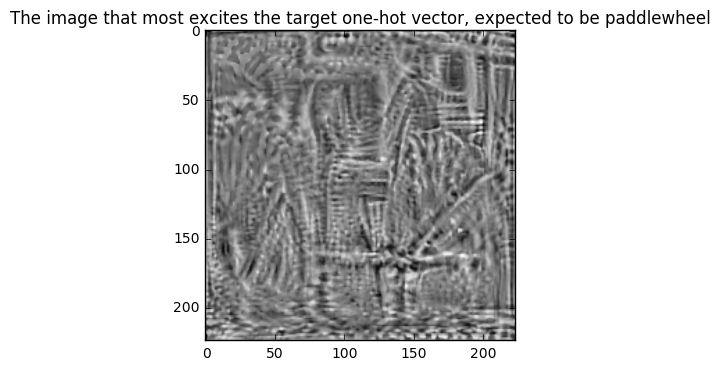

In [7]:
result_image = sess.run(model['input'])
gray = cv2.cvtColor(result_image[0],cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(gray,cmap='gray')
plt.title('The image that most excites the target one-hot vector, expected to be paddlewheel')
scipy.misc.imsave('output/final.png', gray)